# Notebook structure

- [Approach idea](#Approach-idea)
- [Common section for all sub-tasks](#Common-section-for-all-sub-tasks)
- [Outcomes data for COVID-19 after mechanical ventilation adjusted for age](#Outcomes-data-for-COVID-19-after-mechanical-ventilation-adjusted-for-age) -> [results](#Display-results)
- [Model recalculation](#Model-recalculation)


# Approach idea

### PROS

- todo
- todo

### CONS

- todo
- todo


# Common section for all sub-tasks

### Installation of required packages

In [261]:
!pip install inverness

### Model load

In [104]:
import inverness
model = inverness.Model('model_all_v7/').load(['fun','meta','phraser','dictionary','tfidf','lsi','dense_ann'])

load done in 2.94 seconds


### Standard imports

In [105]:
from IPython.core.display import display, HTML
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import re
pd.set_option('display.max_rows', 100)

### Helper functions


In [106]:
def score_text(text, criteria):
    """"""
    total = 0
    value = 1
    for c in criteria:
        if type(c) in (int,float):
            value = c
        else:
            c = c.replace('_',r'\b')
            matches = re.findall(c,text,re.I)
            total += value if matches else 0
            #total += value*len(matches)
    return total


def score_results(i_d_lists, criteria, mark=None):
    """"""
    results = []
    for i,d in zip(*i_d_lists):
        doc = model.get_doc(i)
        text = model.doc_to_text(doc).replace('\n',' ').replace('\r',' ')
        s = score_text(text, criteria)
        html = highlight(text, criteria, style_by_group_id, default_style)
        rec = s,d,i,html,doc
        results += [rec]
    results.sort(key=lambda x:(-x[0],x[1]))
    return results


# TODO ??? tqdm
def score_queries(queries, criteria, K=50):
    """"""
    by_score = []
    for query in queries:
        q = model.text_to_dense(query)
        i_d = model.dense_ann_query(q,K)
        results = score_results(i_d, criteria)
        score = agg_results(results)
        by_score += [(score,query)]
    by_score.sort()
    return by_score


def highlight(text, criteria, styles={}, default='w=bold'):
    """"""
    group_id = 0
    for c in criteria:
        if type(c) in (int,float):
            group_id += 1
        else:
            c = c.replace('_',r'\b')
            c = f'({c}\\w*)'
            style = styles.get(group_id,default)
            style_props = []
            for prop in style.split(','):
                k,_,v = prop.partition('=')
                if k=='w':
                    style_props += [f'font-weight:{v}']
                if k=='fg':
                    style_props += [f'foreground-color:{v}']
                if k=='bg':
                    style_props += [f'background-color:{v}']
            before = f'<span style="{";".join(style_props)}">'
            after = '</span>'
            text = re.sub(c, before+'\\1'+after, text, flags=re.I)
            # TODO default
    return text


# L2 score
def agg_results(results):
    """"""
    scores = [x[0] for x in results]
    return sum([x*x for x in scores])**0.5


# TODO break title into multiple lines
def plot_results(results,title=''):
    """"""
    scores = [x[0] for x in results]
    scores.sort(reverse=True)
    plt.plot(scores)
    if title: plt.title(title)
    score = agg_results(results)
    plt.figtext(0.4, 1, f"L2 score: {score:.02f}")
    plt.show()

    
# TEST
#highlight_old("this is a test of this function",['thi',5,'_is'],mark=[1])
#highlight("this is a test of this function",['thi',5,'_is'],styles={0:'w=bold',1:'bold,bg=#FF0000,fg=#0000FF'})
#highlight("this is a test of this function",['thi',5,'_is'])

## Outcomes data for COVID-19 after mechanical ventilation adjusted for age

### Scoring criteria

#### Color codes:

- **green** - positive outcome
- **red** - negative outcome
- **amber** - estimator
- **yellow** - age related
- **cyan** - outcome / result
- **magenta** - table / chart / figure


In [257]:
criteria = [
    50,'mechanical','ventilat',
    2,'adjust','_age','_years','_old',
    2,'_surviv','discharge','extubate','alive',
    2,'nonsurviv','_died','dead','death','mortality','complication',
    5,'Kaplan.Meier','APACHE','SOFA','RIFLE','Glasgow.Coma','GCS','SAPS','_RESP_','RSBI','1000.person_',
    2,'figure','_fig[.]','_table',
    2,'outcome','result','occurr','cohort','median',
    1,'duration','time','_day','patients','_stay','_week'
]

style_by_group_id = {1:'w=bold',2:'bg=#FFFF00',3:'bg=#00FF00',4:'bg=#FFAAAA',5:'bg=#FFCC00',6:'bg=#FFAAFF',7:'bg=#00FFFF'}
default_style = ''

# https://www.mdcalc.com/covid-19

### Query selection

While we could query our model with verbatim task question the intuition/experience tells that keyword based query can give better results.

Here we score different queries (including verbatim task question) using criteria defined above.

In [258]:
K = 50
queries = [
        'Outcomes data for COVID-19 after mechanical ventilation adjusted for age',
        'results after mechnical ventilation discharged dead died',
        'results after mechnical ventilation discharged dead died survived survivors adjusted age years old',
        'results after mechnical ventilation discharged died survived survivors extubated adjusted',
        'results after mechnical ventilation discharged dead died survived survivors adjusted age years old',
        'results after mechnical ventilation discharged died survived extubated adjusted',
        'results after mechnical ventilation discharged died survived extubated adjusted age',
        'outcomes after mechnical ventilation discharged died survived extubated adjusted',
        'results outcomes after mechnical ventilation discharged died survived extubated adjusted age',
        'results outcomes after mechnical ventilation discharged died survived extubated',
        'results outcomes mechnical ventilation discharged died survived extubated',
        'results outcomes after mechnical ventilation discharged died survived extubated adjusted',
]

for score,query in score_queries(queries, criteria, K):
    print(f"{score:10.02f} -- {query}")

     58.02 -- results after mechnical ventilation discharged dead died survived survivors adjusted age years old
     58.02 -- results after mechnical ventilation discharged dead died survived survivors adjusted age years old
    446.41 -- results after mechnical ventilation discharged died survived extubated adjusted age
    546.58 -- results outcomes after mechnical ventilation discharged died survived extubated adjusted age
    603.41 -- Outcomes data for COVID-19 after mechanical ventilation adjusted for age
    690.27 -- results after mechnical ventilation discharged dead died
    704.74 -- results outcomes after mechnical ventilation discharged died survived extubated
    718.88 -- results outcomes mechnical ventilation discharged died survived extubated
    726.37 -- outcomes after mechnical ventilation discharged died survived extubated adjusted
    731.40 -- results after mechnical ventilation discharged died survived extubated adjusted
    753.34 -- results after mechnical ve

### Final query

In [241]:
query = 'results outcomes after mechnical ventilation \n discharged died survived extubated adjusted'

### Query the model

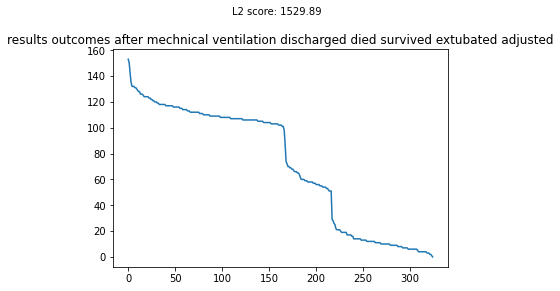

In [259]:
K = 500
q = model.text_to_dense(query)
i_d_lists = model.dense_ann_query(q, K)
results = score_results(i_d_lists, criteria, mark)
plot_results(results, title=query)

### Display results

In [260]:
N = 20
for score,dist,i,html,doc in results[:N]:
    display(HTML(f"{score} :: {dist:.03f} :: {i}<br>{html}"))

# Model recalculation